## Cargamos las librerias necesarias

In [2]:
!pip install serial

In [3]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
import os
import serial
import time

## Cargamos el archivo de audio

In [4]:
archivo_audio = 'audios_recording_01.wav'
samplerate, data = wavfile.read(archivo_audio)

C:\Users\Lio\AppData\Local\Temp\ipykernel_19404\3479999113.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read(archivo_audio)


## Vemos las caracteristicas del audio

In [14]:
muestras = len(data)
duracion = muestras / samplerate
print(f"Duracion = {duracion:.2f} seg")
print(f"Frecuencia = {samplerate} Hz")
print(f"Muestras = {muestras}")

Duracion = 43.37 seg
Frecuencia = 22050 Hz
Muestras = 956253


In [15]:
minimo = min(data)
maximo=max(data)
print(f"Mínimo = {minimo}")
print(f"Máximo = {maximo}")


Mínimo = -32768
Máximo = 32767


In [17]:
print(f"Tipo de dato: {data[0].dtype}")

Tipo de dato: int16


In [34]:
print(f"Primeros 5 datos: {data[:5]}")

Primeros 5 datos: [-107 -121 -122 -128 -109]


## Graficamos la forma de la onda

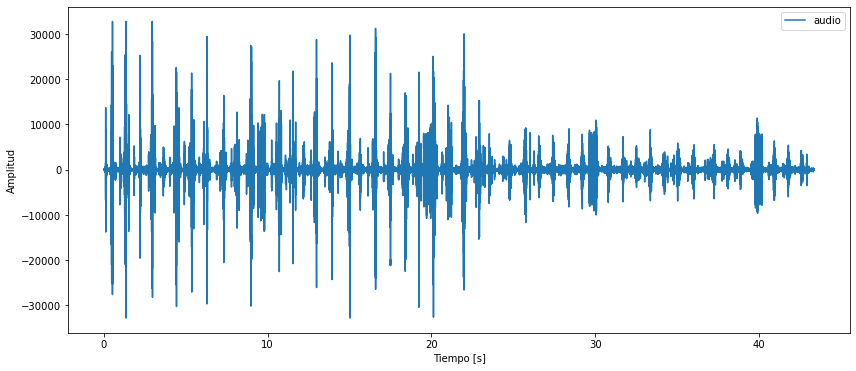

In [21]:
time = np.linspace(0., duracion, muestras)
plt.figure(figsize=(14, 6))
plt.plot(time, data, label="audio")
plt.legend()
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.show()

## Generamos el algoritmo para la compuerta de ruido

In [52]:
def puerta_ruido(umbral_apertura:int,umbral_cierre:int,t_hold:float,samplerate:int,data_audio:np.dtype):
    muestras = len(data)
    duracion = muestras / samplerate
    ## En lugar de compara por tiempo comparo por cantidad de muestras para evitar divisiones
    cant_muestras_hold = int(samplerate * t_hold)
    muestra_para_corte = 0
    abierto = False
    data_out = np.zeros_like(data)
    for indice, valor in enumerate(data_audio):
        valor_abs = abs(valor)
        
        if valor_abs >= umbral_apertura:
            abierto = True   
            muestra_para_corte = 0
        elif abierto:
            if valor_abs < umbral_cierre and muestra_para_corte >= cant_muestras_hold:
                abierto = False
            else:
                muestra_para_corte +=1
        
        data_out[indice] = valor if abierto else 0
    return data_out    
    

In [60]:
UMBRAL_APERTURA = 4000
UMBRAL_CIERRE = 300
T_HOLD = 0.4

sonido_filtrado = puerta_ruido(UMBRAL_APERTURA,UMBRAL_CIERRE,T_HOLD,samplerate, data)

### Genero un segundo algoritmo que recibe de a un dato, de forma de simular el procesamiento en el embebido

In [70]:
def puerta_ruido2(umbral_apertura:int,umbral_cierre:int,t_hold:float,samplerate:int,data_audio:np.dtype):
    
    muestras = len(data)
    duracion = muestras / samplerate
    ## En lugar de compara por tiempo comparo por cantidad de muestras para evitar divisiones
    cant_muestras_hold = int(samplerate * t_hold)
    abierto = False
    muestra_para_corte = 0
    
    def procesa_muestra(valor_in):
        nonlocal abierto
        nonlocal muestra_para_corte
        valor_abs = abs(valor_in)
        
        if valor_abs >= umbral_apertura:
            abierto = True   
            muestra_para_corte = 0
        elif abierto:
            if valor_abs < umbral_cierre and muestra_para_corte >= cant_muestras_hold:
                abierto = False
            else:
                muestra_para_corte +=1    
        
        return valor_in if abierto else 0
    
    data_out = np.zeros_like(data)
    for indice, valor in enumerate(data_audio):
        data_out[indice] = procesa_muestra(valor)
    return data_out    

In [71]:
sonido_filtrado2 = puerta_ruido2(UMBRAL_APERTURA,UMBRAL_CIERRE,T_HOLD,samplerate, data)

## Graficamos el audio original y el filtrado para ver las diferencias

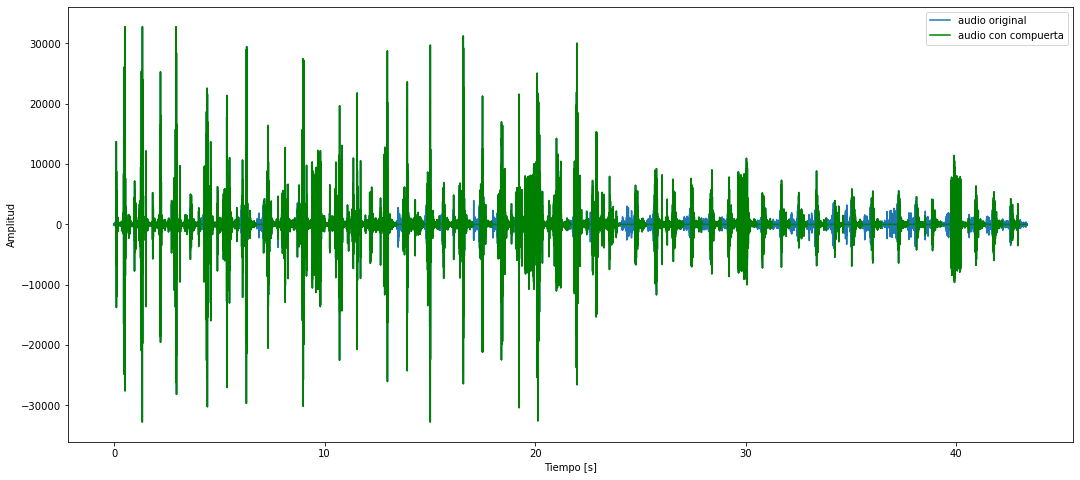

In [62]:
time = np.linspace(0., duracion, muestras)
plt.figure(figsize=(18, 8))
plt.plot(time, data, label="audio original")
plt.plot(time, sonido_filtrado, label="audio con compuerta",color='green')
plt.legend()
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.show()


## Graficamos por separado

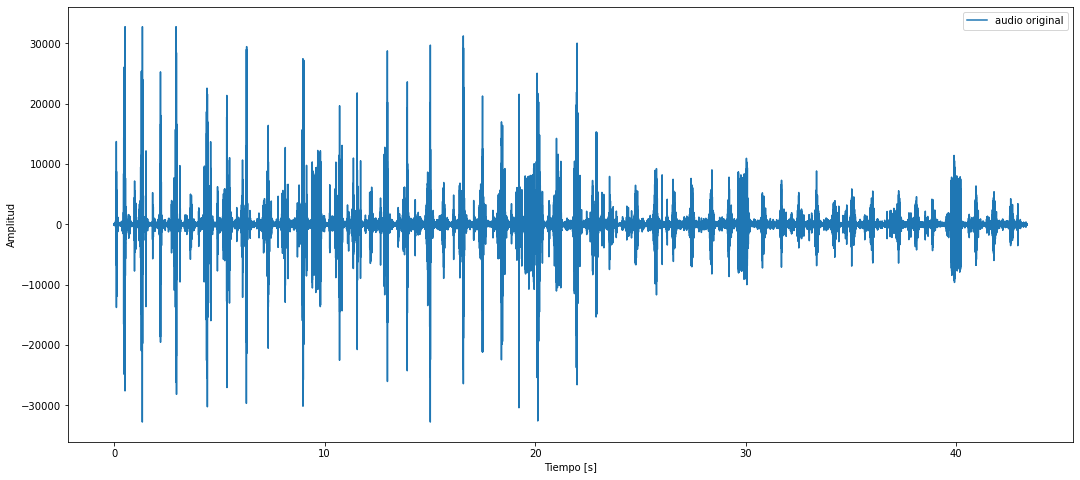

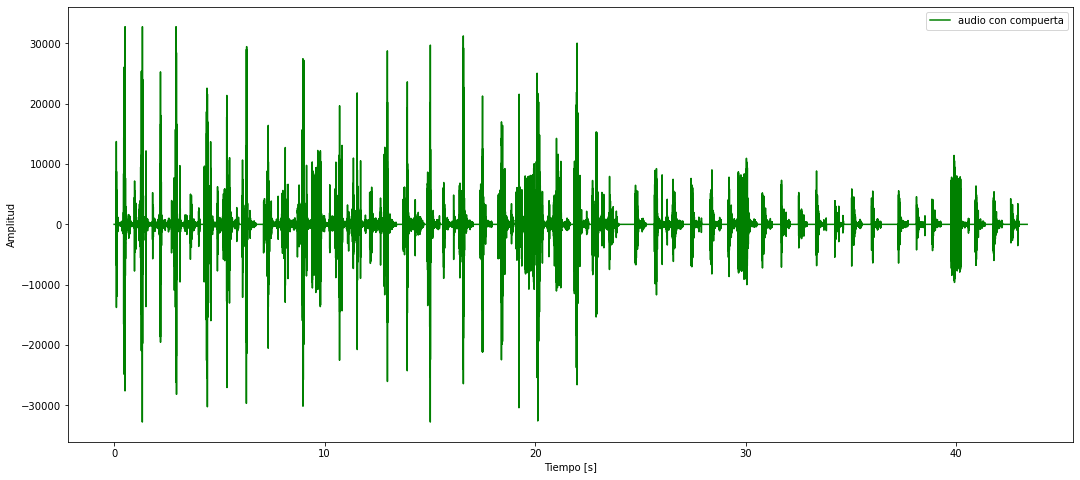

In [63]:
time = np.linspace(0., duracion, muestras)
plt.figure(figsize=(18, 8))
plt.plot(time, data, label="audio original")
plt.legend()
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.show()

time = np.linspace(0., duracion, muestras)
plt.figure(figsize=(18, 8))
plt.plot(time, sonido_filtrado, label="audio con compuerta",color='green')
plt.legend()
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.show()